# Take home task

- Output of an Undamaged-Repair-Replace (URR) classifier
- per part detects whether the part is undamaged or whether it needs to be repaired or replaced
- parts that are lightly damaged are typically repaired and parts that are heavily damaged are typically replaced 
- undamaged < repair < replace

Task:
- based on the URR classifier output and some ground-truth metadata, find the right thresholds/ decision boundaries that distinguish the three classes - undamaged, repair and replace

<img src="img/car_parts.jpg" alt="drawing" width="700"/>

In [50]:
import glob

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, precision_recall_fscore_support, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import scipy
import seaborn as sns

# Data

## Metadata
Claim data:
- claim_id: A unique ID for a claim
- make: Make description of the vehicle
- model: Model description of the vehicle
- year: Model year of the vehicle
- poi: The main point of impact (eg. Front Centre, Right Rear Corner, etc.)

Line data:
- line_num: Number of the line item
- part: Name of part (eg. fbumper, bbumper, etc.)
- operation: Name of operation (eg. repair, replace)
- part_price: Total price of the part if replaced in \\$
- labour_amt: Total labour amount to perform the operation in \\$

Additional info:
- a claim can have multiple line items (the claim data columns will be the same, and the line data columns differ)
- the line data contains information on the damaged parts for the claims: the operation (repair or replace) performed on the part and the cost associated with the operations
- If there isn’t a line for a part in a claim, assume that that part is undamaged
- Also assume that the vehicle details (make, model, year) and point of impact (poi) are known at inference time

In [96]:
def read_folder_to_pd(path):
    """ Read all files in a folder into a pandas dataframe. """
    all_files = sorted(glob.glob(path + "/*.csv"))

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    return pd.concat(li, axis=0, ignore_index=True)

In [97]:
metadata = read_folder_to_pd("./tractable_ds_excercise_data/metadata/")

In [98]:
metadata = metadata.sort_values(by=["claim_id", "line_num"]).reset_index(drop=True)

In [99]:
metadata.head(10)

,claim_id,make,model,year,poi,line_num,part,operation,part_price,labour_amt
0,0,Volkswagen,Tiguan,2010.0,Rear Centre,1,bbumper,replace,266.600006,110.000005
1,1,Peugeot,307,2003.0,Rear Left,1,bbumper,replace,308.920013,55.000002
2,1,Peugeot,307,2003.0,Rear Left,2,bldoor,repair,NaN,55.000001
3,1,Peugeot,307,2003.0,Rear Left,3,blwing,replace,337.709991,114.999998
4,2,Volkswagen,Vw,2007.0,Front Centre,1,fbumper,replace,294.000000,115.000007
5,3,Ford,Ka,2009.0,NaN,1,bbumper,replace,207.009995,50.000001
6,3,Ford,Ka,2009.0,NaN,2,brwing,repair,NaN,225.000000
7,4,Citroen,Jumper,2006.0,NaN,1,bbumper,repair,NaN,15.000001
8,4,Citroen,Jumper,2006.0,NaN,2,brdoor,repair,NaN,585.000002
9,4,Citroen,Jumper,2006.0,NaN,3,brwing,repair,NaN,555.000007


<AxesSubplot:title={'center':'Model year'}>

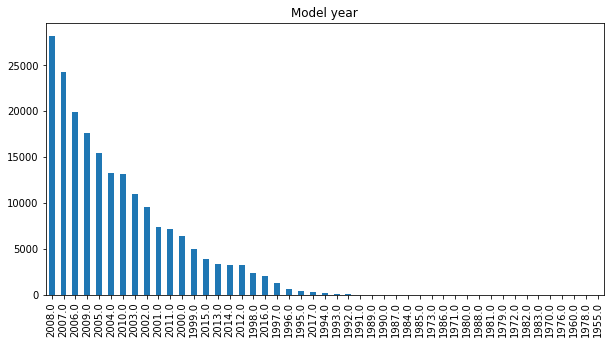

In [106]:
metadata['year'].value_counts().plot(kind='bar',
                                    figsize=(10,5),
                                    title="Model year")

<AxesSubplot:title={'center':'Car brands'}>

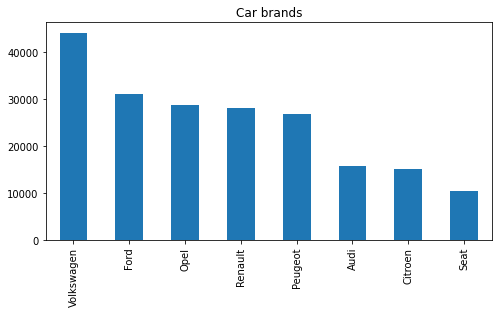

In [93]:
metadata['make'].value_counts().plot(kind='bar',
                                    figsize=(8,4),
                                    title="Car brands")

<AxesSubplot:title={'center':'Points of impact'}>

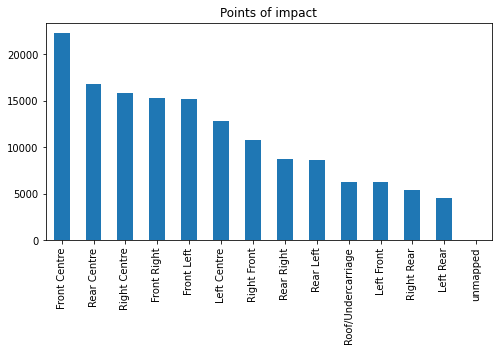

In [95]:
metadata['poi'].value_counts().plot(kind='bar',
                                    figsize=(8,4),
                                    title="Points of impact")

## Classifier output

Classifier output data:
- claim_id: A unique ID for the claim
- part: Name of part (eg. fbumper, bbumper, etc.)
- urr_score: Undamaged / Repair / Replace score, float value ranging from 0 to 1
- set: The set (train/val/test) that the claim belongs to, where 0 => train, 1 => val and 2 => test

Additional info:
- For each claim, the classifiers output scores for all 10 parts, so there will be 10 lines per claim in this file
- If the classifier score is missing, that means that the part was not identified by the AI in the images provided

In [101]:
clf_output = pd.read_csv("./tractable_ds_excercise_data/classifier_output.csv")

In [102]:
# dropping all NaNs because here NaN means the part was not identified, hence the score is not "undamaged" but meaningless
clf_output = clf_output.dropna(axis=0).reset_index(drop=True)

In [103]:
clf_output.head(10)

,claim_id,part,urr_score,set
0,0,fbumper,0.464102,0
1,0,bbumper,0.680342,0
2,0,blwing,0.899217,0
3,1,bbumper,0.790558,0
4,1,bldoor,0.050809,0
5,1,fldoor,0.085575,0
6,1,blwing,0.979714,0
7,2,fbumper,0.599913,0
8,2,bbumper,0.645391,0
9,2,bldoor,0.331490,0


# Tasks

# Part 1
- improve the performance of the URR classifier by determining the right thresholds/decision boundaries between the three classes (undamaged/repair/replace)
- the purpose of the final system is to predict which parts need to be repaired and replaced in a given claim, but your task stops at finding the thresholds

## Task 1
Determine ground-truth labels from the metadata and merge the two data dumps for analysis (expected content in hand-in: code)

In [104]:
data = clf_output.merge(metadata[["claim_id", "part", "operation"]], on=["claim_id", "part"], how="left")
# here we fill all NaNs with "undamaged" because when a line is not in the metadata we can assume the part is undamaged
data["operation"] = data["operation"].fillna("undamaged")

In [105]:
data.head(10)

,claim_id,part,urr_score,set,operation
0,0,fbumper,0.464102,0,undamaged
1,0,bbumper,0.680342,0,replace
2,0,blwing,0.899217,0,undamaged
3,1,bbumper,0.790558,0,replace
4,1,bldoor,0.050809,0,repair
5,1,fldoor,0.085575,0,undamaged
6,1,blwing,0.979714,0,replace
7,2,fbumper,0.599913,0,replace
8,2,bbumper,0.645391,0,undamaged
9,2,bldoor,0.331490,0,undamaged


#### Checking for dataset imbalance

undamaged: 72.0%
repair: 19.3%
replace: 8.7%


<AxesSubplot:ylabel='operation'>

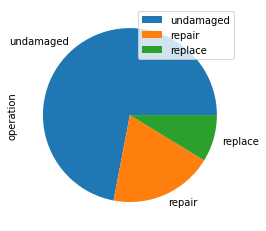

In [12]:
class_count = data["operation"].value_counts()
for op, count in class_count.items():
    print(f"{op}: {round(count/sum(class_count.values), 3)*100}%")
class_count.plot(kind="pie", legend=True)

In [15]:
# constant for number of classes
N_CLASSES = len(data["operation"].unique())

In [16]:
# creating a mapping from category (e.g "undamaged") to label (e.g. 0) and the reverse mapping of that to map back
CAT_TO_LABELS = {}
for category, label in enumerate(class_count.keys()):
    CAT_TO_LABELS[category] = label
    
LABELS_TO_CAT = {label: category for category, label in CAT_TO_LABELS.items()}

## Task 2
Analyse the performance of the classifiers (expected content in hand-in: code, 2-5 bullet-points and 1-3 tables/figures)

### Answer:
- Because we don't have the threshold yet, we can use either ROC or Precision-Recall curves to analyse how the classifier performed for different thresholds
- We will use the Precision-Recall curve because as seen in the cell above, we have an imbalanced dataset (72.0% - 19.3% - 8.7%)
- We have to use a multiclass Precision-Recall curve as there are 3 classes. We convert this into a binary task by treating each class in a one-vs-rest manner.

- The way I am approaching this task is:
    - Given a list of URR scores
    - For each class (undamaged, repair, replace) we are going through all the URR scores
    - For each URR score we are saying: If this is the boundary for this class, what would be the precision, recall, f1 score and precision/recall AUC?
        - That means, for each threshold we are calculating the precision and recall of predictions with score >= threshold
    - By looking at the precision recall curve and the AUC score we can evaluate the classifiers performance without knowing the threshold

In [18]:
# split the dataset into train, val and test set
train_data = data[data["set"] == 0]
val_data   = data[data["set"] == 1]
test_data  = data[data["set"] == 2]

In [19]:
def plot_multiclass_pr(y_pred, y_test, n_classes, figsize=(10, 8), labels={}):
    """ Given a list of prediction scores y_pred and ground truth classes y_test, this function plots the Precision Recall curve for each class. """
    precision = {}
    recall = {}
    f_1_score = {}
    thresholds = {}
    pr_auc = {}
    no_skill = {}

    y_test = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test[:, i], y_pred)
        f_1_score[i] =  (2 * precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)
        pr_auc[i] = auc(recall[i], precision[i])
        no_skill[i] = np.count_nonzero(y_test[:, 0] == 1) / len(y_test)
        
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision Recall curve')
    for i in range(n_classes):
        best_f1_index = np.argmax(f_1_score[i])
        print(f"Best threshold for label {labels.get(i, i)}: {thresholds[i][best_f1_index]}")
        ax.plot(recall[i], precision[i], 
                label=f'PR curve (area = {round(pr_auc[i], 2)}) for label {labels.get(i, i)}')
        ax.scatter(recall[i][best_f1_index], precision[i][best_f1_index], s=100, marker=(5, 1), 
                   label=f'Best F1 score ({round(f_1_score[i][best_f1_index], 2)}) for label {labels.get(i, i)}')
        ax.plot([0, 1], [no_skill[i], no_skill[i]], linestyle='--')
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()

### Train data

Best threshold for label undamaged: 0.2964361011981964
Best threshold for label repair: 0.5995489954948425
Best threshold for label replace: 1.1920928955078125e-07


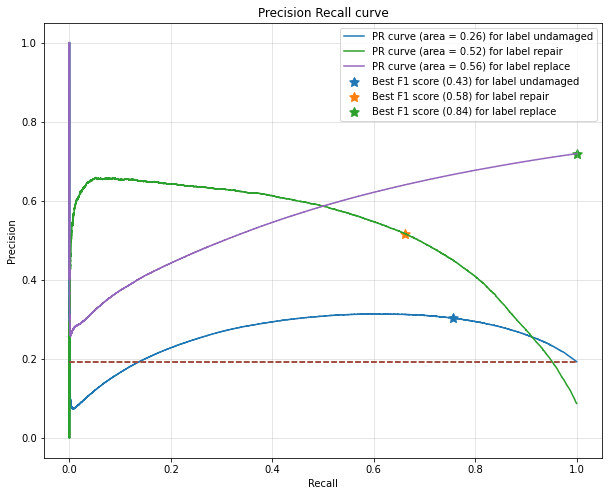

In [20]:
plot_multiclass_pr(y_pred=train_data["urr_score"].values, 
                   y_test=train_data["operation"], 
                   n_classes=N_CLASSES,
                   labels=CAT_TO_LABELS)

### Validation data

Best threshold for label undamaged: 0.30303314328193665
Best threshold for label repair: 0.575984001159668
Best threshold for label replace: 2.5033950805664062e-06


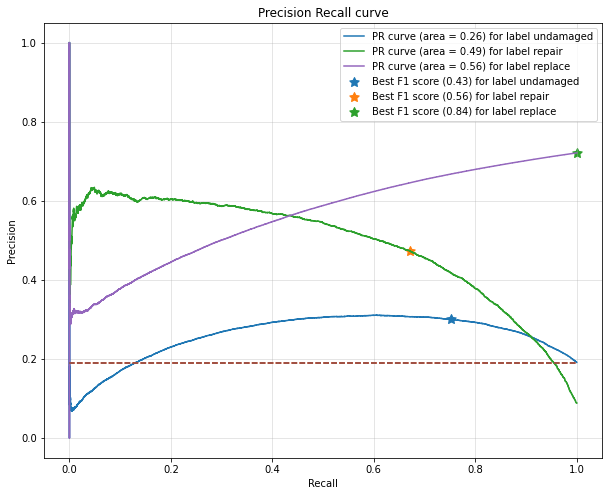

In [21]:
plot_multiclass_pr(y_pred=val_data["urr_score"].values, 
                   y_test=val_data["operation"], 
                   n_classes=N_CLASSES,
                   labels=CAT_TO_LABELS)

### Test data

Best threshold for label undamaged: 0.2887547314167023
Best threshold for label repair: 0.571759045124054
Best threshold for label replace: 2.384185791015625e-07


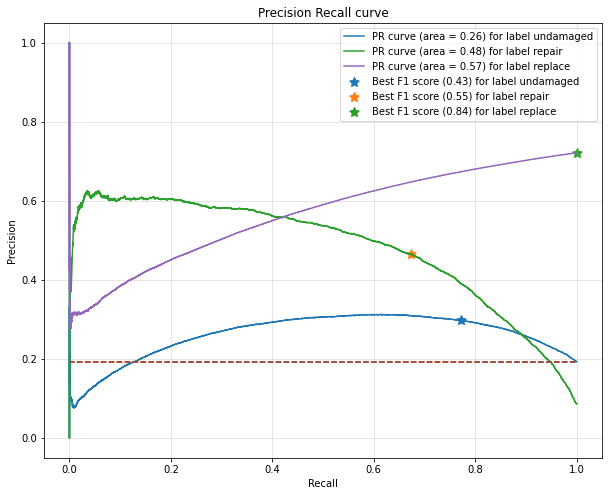

In [22]:
plot_multiclass_pr(y_pred=test_data["urr_score"].values, 
                   y_test=test_data["operation"], 
                   n_classes=N_CLASSES,
                   labels=CAT_TO_LABELS)

## Task 3
Find the optimum thresholds to distinguish the undamaged/repair/replace classes. You are free to choose any objective here (accuracy, true positive rate, etc.) but make sure to justify your choice, and that the justification is sensible (expected content in hand-in: code, 2-5 bullet-points and 1-3 tables/figures)

### Answer:

#### Choosing the objective to optimize for
- Accuracy wouldn't be a good choice here as we have an imbalanced dataset (we could already get 72% out of the box just by always predicting "undamaged")
- When the dataset is skewed it is usually a good idea to go for Precision and Recall or F1 score
- We decided to go for the F1 score as a combined metric of Precision and Recall
    - This is party due to a lack of domain knowledge. If we knew that for example that it's really important to get all "replace" cases at any cost we would've chosen Precision and Recall with the best possible tradeoff
- Because we have a multiclass dataset we calculate our F1 scores as a one-vs-rest for each class, hence we have 3 scores (one per class)
- We decide to use the "weighted" average of the 3 scores because it takes the class imbalance into account


#### Finding the optimum threshold
- First we use scipy's fmin optimizer to minimize the (reversed) F1 score which gives us the best possible threshold
- Secondly we show how we could also plug a simple Logistic Regression model on top of our URR scores to get the classes (this doesn't give us the thresholds though)
- The fmin optimization method performs better, achieving a F1 score of 0.7184 while the (not optimized) Logistic Regression got 0.6607 on the test set

In [24]:
def get_y_true_and_scores(data):
    """ Retrieve the true classes and the predicted URR score for a given dataset. """
    y_true = np.where(data["operation"] == "replace", 2, np.where(data["operation"] == "repair", 1, 0))
    y_scores = data['urr_score'].values
    return y_true, y_scores

In [25]:
def get_y_pred_w_threshold(y_scores, threshold):
    """ Apply a given threshold to y_scores to turn it into a list of predictions. """
    return np.where(y_scores > threshold[1], 2, np.where(y_scores > threshold[0], 1, 0))

### Using scipy's optimizer

In [26]:
# use the training and validation data for tuning
y_true_train, y_scores_train = get_y_true_and_scores(train_data.append(val_data))
y_true_test, y_scores_test = get_y_true_and_scores(test_data)

In [83]:
def threshold_to_f1(threshold, y_true, y_scores, average="weighted"):
    """ This function first calculates the class predictions given a list of predicted URR scores by applying the given threshold. It then returns the F1 score. """
    y_pred = get_y_pred_w_threshold(y_scores, threshold)
    return -f1_score(y_true, y_pred, average=average)

#### Training

In [ ]:
best_thr = scipy.optimize.fmin(threshold_to_f1, args=(y_true_train, y_scores_train), x0=[0.1, 0.9])
print(f"Best threshold: {best_thr}")

#### Evaluation

In [30]:
y_pred_test = get_y_pred_w_threshold(y_scores_test, best_thr)

precision, recall, f_1_score, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average="weighted")
print(f"Precision: {round(precision, 4)}\nRecall:    {round(recall, 4)}\nF1 Score:  {round(f_1_score, 4)}")

Precision: 0.7228
Recall:    0.7146
F1 Score:  0.7184


#### Confusion Matrix

<AxesSubplot:>

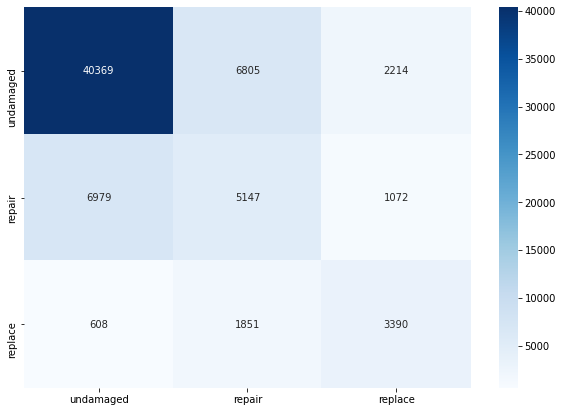

In [67]:
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt="g", xticklabels=CAT_TO_LABELS.values(), yticklabels=CAT_TO_LABELS.values())

### Logistic Regression
- Here we are plugging the raw scores of the URR classfier into a Logistic Regression model
- We are training the Logistic Regression model using the URR scores as input data and the corresponding class labels as testing data

In [68]:
# Getting the training, validation and testing data
y_train_lr, x_train_lr = get_y_true_and_scores(train_data)
y_val_lr, x_val_lr = get_y_true_and_scores(val_data)
y_test_lr, x_test_lr = get_y_true_and_scores(test_data)

x_train_lr = x_train_lr.reshape(-1, 1)
x_val_lr = x_val_lr.reshape(-1, 1)
x_test_lr = x_test_lr.reshape(-1, 1)

#### Training

In [69]:
# Specifying the Logistic Regression model (we could use a grid search here to get better parameters)
clf_lr = LogisticRegression(C=1.0, penalty='l2')
clf_lr.fit(x_train_lr, y_train_lr)
clf_lr.score(x_val_lr, y_val_lr)

0.7374365762188396

#### Evaluation

In [70]:
y_pred_lr = clf_lr.predict(x_test_lr)
precision, recall, f_1_score, _ = precision_recall_fscore_support(y_test_lr, y_pred_lr, average="weighted")
print(f"Precision: {round(precision, 4)}\nRecall:    {round(recall, 4)}\nF1 Score:  {round(f_1_score, 4)}")

Precision: 0.6389
Recall:    0.737
F1 Score:  0.6607


In [71]:
# Computing one example manually
example_calculation = (clf_lr.coef_ * x_test_lr[0]).T + clf_lr.intercept_
example_calculation[0]

array([-0.6281683 , -0.03378587,  0.66195417])

In [72]:
print(f"Predicted class: {np.argmax(example_calculation[0])}\nActual class:    {y_pred_lr[0]}")

Predicted class: 2
Actual class:    2


In [73]:
clf_lr.coef_, clf_lr.intercept_

(array([[-4.82921036],
        [-0.59824156],
        [ 5.42745193]]),
 array([ 3.1374188 ,  0.43269426, -3.57011306]))

#### Confusion matrix

<AxesSubplot:>

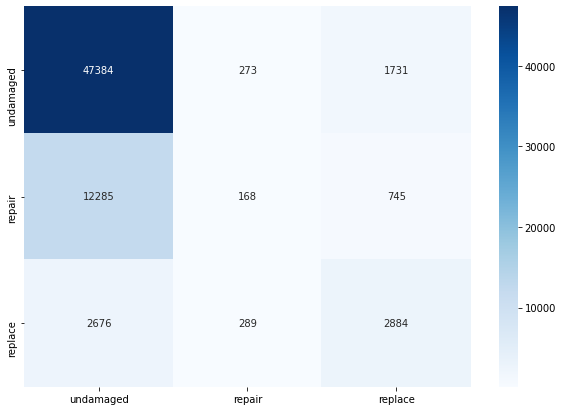

In [76]:
cm = confusion_matrix(y_test_lr, y_pred_lr)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt="g", xticklabels=CAT_TO_LABELS.values(), yticklabels=CAT_TO_LABELS.values())

# Part 2

- discuss how to take this solution closer to something that could be used live

## ~~Task 4~~~
- discuss ways you would scale your code to ingest more data, i.e. of the order of millions (expected content in hand-in: 2-5 bullet-points)

### Answer:
- use Spark instead of Pandas

## ~~Task 5~~~
- discuss ways you would further improve the performance of the classifiers if you had more time (expected content in hand-in: 2-5 bullet-points)

## Task 6
- predict the cost of performing the operations for a particular claim as a function of the URR scores and the claim data
- How would you design a system that can predict these costs? 
- Which metadata fields would you use? 
- Would you also require any additional data (not provided in the data dump) that will help you improve the accuracy of your estimate? 
(expected content in hand-in: 5-10 bullet-points)

### Answer:

#### Designing a system to predict the costs
- The model would take the URR scores as well as certain metadata fields as its input data
    - $f(URR\_scores, make, model, year, poi) = cost\_of\_operation$
- We would need a regression model
    - Popular choices include: linear regression, regression trees, random forest, xgboost, support vector regression, neural network
- "labour_amt" would be the target column (it wasn't clear from the description if it's only "labour_amt" but I would assume it is because "part_price" could be done via a lookup table)
    - If the target columns are both "labour_amt" and "part_price" we could train a model for each or predict the two with the same model (I would choose to do the latter because there is a lot of overlap in the parameters that are relevant)
- Because both fields can get quite large, we would normalize them ("learn" mean and variance from train set and apply to val and test set to avoid data leakage)
    - We can then use the mean and variance to reverse the normalization to get our actual values to generate our report


#### Metadata fields
- To choose which metadata fields would be useful we would check which fields are most correlated to the "part_price" and "labour_amount" (example for "make" below)
    - If a field (feature) shows close to 0 correlation, it's probably useless
- My intuition tells me that there is probably some correlation between the "make" and "model" of a car to how much it will cost to repair/replace it, e.g. crashing the trunk of a Tesla is most likely more expensive than crashing the trunk of a Fiat.
- There will also probably be a correlation between "poi" and the final price, e.g. fixing the door is more expensive than fixing the back bumper
    

#### Feature engineering
- If we use a linear regression of neural net:
    - Once we have chosen the metadata fields we would need to one-hot-encode our features "make", "model", "poi"
        - It wouldn't make sense to label encode them because there is no particular order in any of them
        - Because one-hot-encoding will result in a very sparse input vector, we could try out other encoding methods like target encoding or count encoding (target makes more sense here)
    - I would also convert year into a numerical representation. I can imagine "age" would work well as the parts and labour might get more expensive the older the car is because parts might be more rare. It wouldn't be the amount of years the car has been driven but rather the amount of years since it has been first released.
        - The problem we run into here is that if we use (current_year - build_year) as our definition of age, it changes every year and we'd have to retrain our model at least on a yearly basis
        - As an alternative we could again, try the target encoding
- If we use a decision tree we don't need to worry as much about encoding the categorical variables as DTs can handle them quite well


#### Additional data
- It would help to know the country and perhaps even region of the accident, e.g. companies in London will charge more than in Fordwich (which, as of 2011 has 381 inhabitants)
    
 
#### Process
- Find a simple baseline (to assure the model is learning something), we could just take something like average cost per part or per make
- Build a simple ML model to beat the baseline (to confirm that ML is even useful for this task)
- Overfit our model (add (bigger) layers, train longer, use bigger model)
- Apply regularization methods and tune hyperparameters (dropout, different architectures, more data, regularization methods)

In [77]:
metadata

,claim_id,make,model,year,poi,line_num,part,operation,part_price,labour_amt
0,0,Volkswagen,Tiguan,2010.0,Rear Centre,1,bbumper,replace,266.600006,110.000005
1,1,Peugeot,307,2003.0,Rear Left,1,bbumper,replace,308.920013,55.000002
2,1,Peugeot,307,2003.0,Rear Left,2,bldoor,repair,NaN,55.000001
3,1,Peugeot,307,2003.0,Rear Left,3,blwing,replace,337.709991,114.999998
4,2,Volkswagen,Vw,2007.0,Front Centre,1,fbumper,replace,294.000000,115.000007
...,...,...,...,...,...,...,...,...,...,...
199822,99996,Volkswagen,Polo,2011.0,Rear Centre,2,blwing,repair,NaN,410.000002
199823,99997,Citroen,C5,2009.0,Front Right,1,fbumper,repair,NaN,70.000002
199824,99997,Citroen,C5,2009.0,Front Right,2,frwing,repair,NaN,130.000001
199825,99998,Citroen,Saxo,2002.0,NaN,1,bbumper,replace,183.279999,60.000002


### Labour amount and Part Price for Volkswagen Tiguan (replace)

In [78]:
t = metadata[(metadata["make"] == "Volkswagen") & 
             (metadata["model"] == "Tiguan") & 
             (metadata["operation"] == "replace")] \
            [["make", "model", "year", "poi", "operation", "part_price", "labour_amt"]] \
            .dropna() \
            .sort_values(by=["year", "poi"])

print(t["labour_amt"].describe())
t.head(10)

count     76.000000
mean     144.013161
std       84.632621
min       40.000001
25%      105.000002
50%      125.000000
75%      195.000005
max      750.000036
Name: labour_amt, dtype: float64


,make,model,year,poi,operation,part_price,labour_amt
52728,Volkswagen,Tiguan,2007.0,Front Centre,replace,273.700012,125.000000
8505,Volkswagen,Tiguan,2008.0,Front Centre,replace,273.700012,135.000002
23511,Volkswagen,Tiguan,2008.0,Front Centre,replace,199.949997,150.000000
43078,Volkswagen,Tiguan,2008.0,Front Centre,replace,282.649994,110.000002
43079,Volkswagen,Tiguan,2008.0,Front Centre,replace,142.600006,85.000002
53054,Volkswagen,Tiguan,2008.0,Front Centre,replace,273.700012,125.000000
116772,Volkswagen,Tiguan,2008.0,Front Centre,replace,250.000000,150.000000
131505,Volkswagen,Tiguan,2008.0,Front Centre,replace,273.700012,110.000002
131506,Volkswagen,Tiguan,2008.0,Front Centre,replace,137.800003,85.000002
32941,Volkswagen,Tiguan,2008.0,Front Left,replace,273.700012,125.000000


### Labour amount for Volkswagen Tiguan (repair)

In [79]:
t = metadata[(metadata["make"] == "Volkswagen") & 
             (metadata["model"] == "Tiguan") & 
             (metadata["operation"] == "repair")] \
            [["make", "model", "year",	"poi", "operation", "labour_amt"]] \
            .dropna() \
            .sort_values(by=["year", "poi"])

print(t["labour_amt"].describe())
t.head(10)

count    281.000000
mean     116.334521
std       82.135006
min       10.000000
25%       45.000002
50%       95.000002
75%      160.000005
max      469.999999
Name: labour_amt, dtype: float64


,make,model,year,poi,operation,labour_amt
118524,Volkswagen,Tiguan,2007.0,Rear Centre,repair,210.000005
701,Volkswagen,Tiguan,2008.0,Front Centre,repair,20.000000
702,Volkswagen,Tiguan,2008.0,Front Centre,repair,85.000002
703,Volkswagen,Tiguan,2008.0,Front Centre,repair,95.000002
8506,Volkswagen,Tiguan,2008.0,Front Centre,repair,95.000002
15853,Volkswagen,Tiguan,2008.0,Front Centre,repair,40.000001
15854,Volkswagen,Tiguan,2008.0,Front Centre,repair,40.000001
15855,Volkswagen,Tiguan,2008.0,Front Centre,repair,75.000000
15856,Volkswagen,Tiguan,2008.0,Front Centre,repair,40.000001
68062,Volkswagen,Tiguan,2008.0,Front Centre,repair,80.000001


### Correlation between car make - part_price, labour_amount

In [80]:
metadata["model"].isna().sum()

0

In [82]:
corr = pd.get_dummies(metadata[["make", "part_price", "labour_amt"]], columns=["make"]).dropna().corr()
corr.style.background_gradient(cmap='coolwarm')

,part_price,labour_amt,make_Audi,make_Citroen,make_Ford,make_Opel,make_Peugeot,make_Renault,make_Seat,make_Volkswagen
part_price,1.000000,0.302957,0.091181,-0.087744,-0.103899,0.113350,0.010720,-0.033487,-0.009123,0.014304
labour_amt,0.302957,1.000000,0.036462,-0.023025,-0.005533,-0.010861,-0.013723,-0.025615,0.006642,0.036507
make_Audi,0.091181,0.036462,1.000000,-0.077360,-0.116065,-0.118373,-0.107140,-0.116230,-0.058140,-0.146042
make_Citroen,-0.087744,-0.023025,-0.077360,1.000000,-0.119179,-0.121548,-0.110014,-0.119347,-0.059700,-0.149959
make_Ford,-0.103899,-0.005533,-0.116065,-0.119179,1.000000,-0.182362,-0.165057,-0.179060,-0.089569,-0.224988
make_Opel,0.113350,-0.010861,-0.118373,-0.121548,-0.182362,1.000000,-0.168338,-0.182620,-0.091350,-0.229461
make_Peugeot,0.010720,-0.013723,-0.107140,-0.110014,-0.165057,-0.168338,1.000000,-0.165291,-0.082681,-0.207687
make_Renault,-0.033487,-0.025615,-0.116230,-0.119347,-0.179060,-0.182620,-0.165291,1.000000,-0.089696,-0.225307
make_Seat,-0.009123,0.006642,-0.058140,-0.059700,-0.089569,-0.091350,-0.082681,-0.089696,1.000000,-0.112703
make_Volkswagen,0.014304,0.036507,-0.146042,-0.149959,-0.224988,-0.229461,-0.207687,-0.225307,-0.112703,1.000000
